<a href="https://colab.research.google.com/github/mgonzal1/nma_wombat_connectivy_project/blob/brain_areas/connectivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
#@title imports and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import sklearn.metrics
import ipywidgets as widgets 
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error


# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


In [2]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)



alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

In [85]:
#@title Representative session
#@markdown As first step, lets choose 1 session to start trainning the model. Let's see which session has more neurons in the areas that we are going to use and how many neurons it has.
import pandas as pd
@widgets.interact
def get_representative_session(min_areas=(0,7)):
  """ To simplify the model we are selecting a session recording with most of the regions represented.
    This interactive function help us to decide the session based on the minimal regions represented and number of 
    total neurons recorded.

  """
  print("")
  brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                  ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                  ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                  ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                  ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                  ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                  ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                  ]
  regions = ["visual ctx", "thal", "hipp", "non-visual ctx", "midbrain", "basal ganglia", "cortical subplate"]
  covered_areas=[]
  for i in range (0,38):
    session = alldat[i]
    brain_areas = set(session['brain_area'])
    representative = []
    neurons_in_area = []
    for group in brain_groups:
        representative.append(any(area in brain_areas for area in group))
    
    if(representative.count(True)>min_areas):
      covered_areas.append(representative)
      print("Session:" , i, "Total neurons:",session['brain_area'].shape[0])
      print("areas:", np.unique(session['brain_area']))

  labels, sizes = np.unique(session['brain_area'], return_counts=True)
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  plt.ylabel("Total of sessions")
  ax.bar(regions,np.count_nonzero(covered_areas, axis=0))
  ax.set_title("Brain areas covered")
  plt.show()

interactive(children=(IntSlider(value=3, description='min_areas', max=7), Output()), _dom_classes=('widget-int…

In [76]:
representative = [True, True, True, True, True, True, False]
np.stack?
a= np.stack([representative,  [False, True, True, True, True, True, False]])
print(a)
np.count_nonzero(a, axis=0)

[[ True  True  True  True  True  True False]
 [False  True  True  True  True  True False]]


array([1, 2, 2, 2, 2, 2, 0])

In [48]:
  brain_groups = {'visual': ["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],
                  'thalamus': ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], 
                  'hippocampal': ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], 
                  'Non-visual': ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], 
                  'midbrain': ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],
                  'basal ganglia' : ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], 
                  'cortical subplate':["BLA", "BMA", "EP", "EPd", "MEA"] 
                  }

df = pd.DataFrame.from_dict(brain_groups, orient='index') 
df.transpose()

,visual,thalamus,hippocampal,Non-visual,midbrain,basal ganglia,cortical subplate
0,VISa,CL,CA,ACA,APN,ACB,BLA
1,VISam,LD,CA1,AUD,IC,CP,BMA
2,VISl,LGd,CA2,COA,MB,GPe,EP
3,VISp,LH,CA3,DP,MRN,LS,EPd
4,VISpm,LP,DG,ILA,NB,LSc,MEA
5,VISrl,MD,SUB,MOp,PAG,LSr,None
6,None,MG,POST,MOs,RN,MS,None
7,None,PO,None,OLF,SCs,OT,None
8,None,POL,None,ORB,SCm,SNr,None
9,None,PT,None,ORBm,SCig,SI,None


In [4]:
# SET DEFAULTS
trial_time = 2
session=12
n_sessions = len(alldat)

In [5]:
#@title General functions to get data
def filter_no_go_choice(data_set):
  """
  In order to reduce the complexity on the decode model(A3), we are removing the no-go trials 
  so we kept binary choice (left or right) that fits with a LogisticRegression model
   Args: 
      data_set: Subset of alldat

  Returns:
   new_data_set (dict): dat['spks']: neurons by trials.
                        dat['brain_area']: brain area for each neuron recorded.
                        dat['contrast_right']: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
                        dat['contrast_left']: contrast level for left stimulus.
                        dat['response']: which side the response was (-1,  1). Choices for the right stimulus are -1.
  """
  new_data_set =  {}
  index_trials = data_set['response'].nonzero()
  # Remove baseline(first 50 bins) and get FR per neuron
  new_data_set.update({"spks":(data_set["spks"][:,index_trials[0],50:].sum(axis=2)/trial_time).T})
  new_data_set.update({"brain_area":data_set["brain_area"]})
  new_data_set.update({"response": data_set["response"][index_trials]})
  new_data_set.update({"contrast_right": data_set["contrast_right"][index_trials]})
  new_data_set.update({"contrast_left": data_set["contrast_left"][index_trials]})
  return new_data_set

def get_spks_from_area(dat,brain_area):
  spks = dat["spks"].T
  n_neurons = spks.shape[0]
  index_neurons = np.zeros(n_neurons,dtype=bool)
  for neuron in range(n_neurons):
    index_neurons[neuron] = dat['brain_area'][neuron] in brain_area

  area_data = (spks[index_neurons,:].T)
  return area_data, index_neurons

def get_visual_ctx(data_set):
  visual_ctx = ["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"]
  visual_data, _ = get_spks_from_area(data_set, visual_ctx)
  return visual_data

def get_motor_ctx(data_set):
  motor_ctx = ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"]
  motor_data, _ = get_spks_from_area(data_set, motor_ctx)
  return motor_data

def get_stimulus(data_set):
  """
   Args: 
      data_set: (map) Subset of alldat
      
   Returns:
      stims[nTrials x 3]  bias: constant with ones
                          stim_left: contrast level for the right stimulus.
                          stim_right: contrast level for left stimulus.
  """


  stims = data_set['contrast_left'], data_set['contrast_right']
  stims = np.array(stims).T
  n_trials = stims.shape[0]
  stims = np.column_stack((np.ones(n_trials),stims))
  return stims

def get_response(data_set):
  """
   Args: 
      data_set: Subset of alldat

   Returns:
        np.array: which side the response was (-1, 0, 1). Choices for the right stimulus are -1.
  """
  response =  np.array(data_set['response'])
  return response

def get_binary_response(data_set):
  """
   To simplify the model we ares going to use a binary response instead of the 3 possible values: left, no-action, right
   to true or false comparing the stimulus to the expected actions. 

   Args: 
      data_set: Subset of alldat

   Returns:
        binary (np.array boolean) : Returns True or False
  """
  vis_left, vis_right = [data_set["stims"][:,1], data_set["stims"][:,2]]
  response = get_response(data_set)
  binary_response = np.sign(response)==np.sign(vis_left-vis_right)
  return binary_response

def split_validation_set(data_set):
  """
  Get a subset of alldat for validation purposes. This should be ~5%-10% of all the data.


  Returns:
   train_set (dict): dat['spks']: neurons by trials.
                     dat['brain_area']: brain area for each neuron recorded.
                     dat['stims']: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
                     dat['response']: which side the response was (-1,  1). Choices for the right stimulus are -1.
  """

  stims=get_stimulus(data_set)
  response = get_response(data_set)
  spk= data_set['spks']
  # # create training and testing vars
  stim_train, stim_test, spk_train, spk_test, response_train, response_test = train_test_split(stims, spk, response, test_size=0.1)
  train_set = {
      "spks": spk_train, 
      "stims": stim_train, 
      "response": response_train, 
      "brain_area":data_set['brain_area']
      }
  validation_set = {
      "spks": spk_test,
      "stims": stim_test, 
      "response": response_test, 
      "brain_area":data_set['brain_area']
      }
  return train_set, validation_set

# Draft of sigmoide calculation
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

In [6]:
# Get train and validation data
data_set = filter_no_go_choice(alldat[session])
data_set, val_set = split_validation_set(data_set)
#train_set (dict): dat['spks']: neurons by trials.
#                  dat['brain_area']: brain area for each neuron recorded.
#                  dat['stims']: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
#                  dat['response']: which side the response was (-1,  1). Choices for the right stimulus are -1.

# MODEL 1:  Encodig from visual stimulus

Using Multiple Linear Regresion:


\begin{align}
y = \theta_0 + \theta_1 x_1 + \theta_1 x_2 + ... +\theta_d x_d + \epsilon
\end{align}

where $\theta_0$ is the intercept and $d$ is the number of features.


Testing with k-fold cross-validation 

**Metrics:**
*   Visual stimulus [nTrials x 3] : Contrast on left and right

\begin{align}
\mathbf{X} = 
\begin{bmatrix}
1 & x_{1,1} & x_{1,2}  \\
1 & x_{2,1} & x_{2,2} \\
\vdots & \vdots & \vdots \\
1 & x_{n,1} & x_{n,2}
\end{bmatrix}
\end{align}


*   Visual neurons matrix [nTrials x Neurons]:  neurons firing rate on visual area

\begin{align}
\mathbf{Y} = 
\begin{bmatrix}
y_{1,1} & y_{1,2} & \dots & y_{1,m}  \\
y_{2,1} & y_{2,2}  & \dots & y_{2,m} \\
\vdots & \vdots  & \dots & \vdots\\
y_{n,1} & y_{n,2} & \dots  &  y_{n,m}
\end{bmatrix}
\end{align}



**Returns**
*  A1 matrix [3x ntrials]

\begin{align}
\mathbf{A1} = 
\begin{bmatrix}
\theta_{1,1} & \theta_{1,2}& \dots \ & \theta_{1,m}\\
\theta_{2,1} & \theta_{2,2}& \dots & \theta_{2,m}\\
\theta_{3,1} & \theta_{3,2}& \dots & \theta_{3,m}\\
\end{bmatrix}
\end{align}





In [7]:
# Get data
visual_dat = get_visual_ctx(data_set)
stim = data_set["stims"]

# Model Linear Regression
model = LinearRegression(fit_intercept=False).fit(stim, visual_dat) 

A1 = model.coef_.T
visual_dat_hat = model.predict(stim)
visual_dat_hat = stim @ A1

#MSE and R2
mse = np.mean( (visual_dat-visual_dat_hat)**2 )
r2_metrics =  sklearn.metrics.r2_score(visual_dat,visual_dat_hat)

print("R2: {}".format(r2_metrics))
print("MSE: {}".format(mse))
 

R2: 0.039757140623770275
MSE: 4.345665295168023


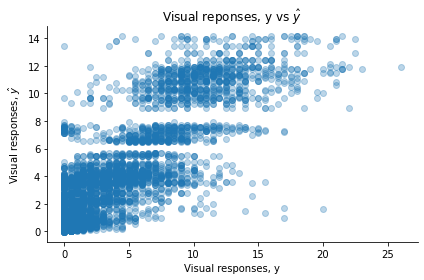

In [8]:
# plt.scatter(visual_dat.flatten(), visual_dat_hat.flatten()) 
plt.scatter(visual_dat,visual_dat_hat, alpha=0.3)
plt.title("Visual reponses, y vs $\hat y$ ")
plt.xlabel("Visual responses, y")
plt.ylabel("Visual responses, $\hat y$")
plt.show()

## Analize correlations per neuron

*   Calculate Root MSE 

 \begin{align}
 RMSE = \sqrt{\sum_{i=1}^N(y_i - \hat y_i)^2}\\
\end{align}

* RMSE normalized per Neuron

\begin{align}
nRMSE = \frac{RMSE}{\bar y}
\end{align}


*   Calculate $R^2$ per Neuron


\begin{align}
R^2 = \frac{\sum_{i=1}^n(\hat y_i - \ y)^2}{\sum_{i=1}^n (y_i - \ \bar{y})^2}
\end{align}



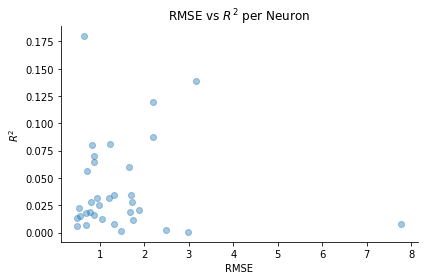

In [9]:
n_visual_dat = np.zeros(visual_dat.shape[1])
n_visual_dat_hat = np.zeros(visual_dat.shape[1])
n_mse = np.zeros(visual_dat.shape[1])
n_r2_metrics = np.zeros(visual_dat.shape[1])
n_mse_norm = np.zeros(visual_dat.shape[1])

for j in range(visual_dat.shape[1]):

  n_visual_dat =visual_dat[:,j]

  model_n = LinearRegression(fit_intercept=False).fit(stim, n_visual_dat)

  A1_n = model_n.coef_.T

  n_visual_dat_hat = stim @ A1_n
  n_visual_dat_mean= np.mean(n_visual_dat)
  
  n_mse [j]= np.mean( (n_visual_dat-n_visual_dat_hat)**2 )
  n_mse_norm [j]= n_mse [j]/ n_visual_dat_mean
  a=np.sum((n_visual_dat_hat-n_visual_dat)**2)
  b=np.sum((n_visual_dat-n_visual_dat_mean)**2)

  
  n_r2_metrics [j] = 1 - (a/b)

plt.scatter(n_mse_norm,n_r2_metrics,alpha=0.4)
plt.title("RMSE vs $R^2$ per Neuron")
plt.xlabel("RMSE")
plt.ylabel("$R^2$")
plt.show()

#Cross-validation: Testing with k-fold 

from Scikit-learn (https://scikit-learn.org/stable/modules/cross_validation.html)

![Diagram from Sklearn](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png ) 


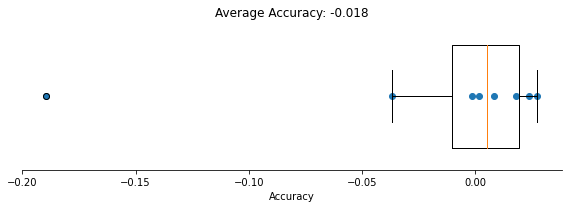

In [10]:
#@title Cross-validation, cv=8
num_splits =8
accuracies = (cross_val_score(model, stim, visual_dat, cv=8))

f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies, vert=False, widths=.7)
ax.scatter(accuracies, np.ones(num_splits))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average Accuracy: {np.mean(accuracies):.3f}"
)
ax.spines["left"].set_visible(False)

# MODEL2: Connectivity Matrix ,  The black box

We try different models for our "black box" and we did some comparissons among them. 

*Spoiler alert, all were bad!*

For future work we need to understand better the correleation between this areas and probabaly make a better decision on the brain areas . 
 
##Models:
* Ridge
* Linear Regression
* Neural Network

**Metrics:**

* Visual data hat `[nTrials x nNeurons_visual]` :  predicted by the encoding model 1. Spikes rates of neurons involved in visual function.

\begin{align}
\mathbf{\hat Y} = 
\begin{bmatrix}
y_{1,1} & y_{1,2} & \dots & y_{1,m}  \\
y_{2,1} & y_{2,2}  & \dots & y_{2,m} \\
\vdots & \vdots  & \dots & \vdots\\
y_{n,1} & y_{n,2} & \dots  &  y_{n,m}
\end{bmatrix}
\end{align}

* Motor data hat `[nTrials x nNeurons_motor]`: predicted by the model 3. Spikes rates of neurons involved in motor function.

\begin{align}
\mathbf{\hat M} = 
\begin{bmatrix}
y_{1,1} & y_{1,2} & \dots & y_{1,m}  \\
y_{2,1} & y_{2,2}  & \dots & y_{2,m} \\
\vdots & \vdots  & \dots & \vdots\\
y_{n,1} & y_{n,2} & \dots  &  y_{n,m}
\end{bmatrix}
\end{align}

**Returns**:
* A2 `[nNeurons_visual , nNeurons_motor]`: Weight  matrix of connectivity model (visual area to motor area)


\begin{align}
\mathbf{A2} = 
\begin{bmatrix}
\theta_{1,1} & \theta_{1,2}& \dots \ & \theta_{1,m}\\
\theta_{2,1} & \theta_{2,2}& \dots & \theta_{2,m}\\
\vdots & \vdots  & \dots & \vdots\\
\theta_{n,1} & \theta_{n,2}& \dots & \theta_{n,m}\\
\end{bmatrix}
\end{align}




### Model Ridge (aka the first try!)

Regularization with ridge penalty (L2).

$$-\log\mathcal{L}'(\theta | X, y)=
-\log\mathcal{L}(\theta | X, y) +\frac\beta2\sum_i\theta_i^2,
$$



In [11]:
# obtains motor areas matrix and sets model
motor_dat = get_motor_ctx(data_set)
ridge = Ridge(alpha=1,fit_intercept=False)
# obtains weight matrix A2
ridge.fit(visual_dat_hat, motor_dat) 
A2 = ridge.coef_.T
# obtains prediction
motor_dat_hat = visual_dat_hat@A2

# MSE & R2
print("ridge MSE:", mean_squared_error(motor_dat, motor_dat_hat))
print("ridge score:",ridge.score(visual_dat_hat, motor_dat))


ridge MSE: 13.90247727923903
ridge score: 0.07111341882142855


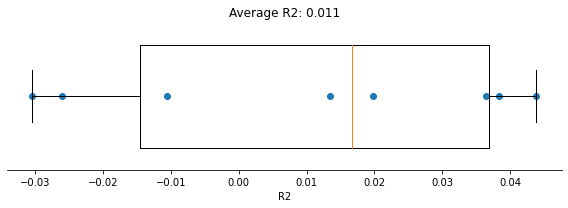

In [12]:
#@markdown Cross-validation, cv=8
num_splits =8
accuracies_ridge = (cross_val_score(ridge, visual_dat_hat, motor_dat, cv=8))

f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies_ridge, vert=False, widths=.7)
ax.scatter(accuracies_ridge, np.ones(num_splits))
ax.set(
  xlabel="R2",
  yticks=[],
  title=f"Average R2: {np.mean(accuracies_ridge):.3f}"
)
ax.spines["left"].set_visible(False)

## Model Linear Regression 

\begin{align}
y = \theta_0 + \theta_1 x_1 + \theta_1 x_2 + ... +\theta_d x_d + \epsilon
\end{align}

In [13]:
#@markdown  Linear Regression 
# obtains motor areas matrix and sets model
model_A2_lin = LinearRegression(fit_intercept=False).fit(visual_dat_hat, motor_dat) 

A2_lin = model_A2_lin.coef_.T

motor_dat_hat_lin = model_A2_lin.predict(visual_dat_hat)

mse_A2_lin = mean_squared_error (motor_dat, motor_dat_hat_lin)

r2_metrics_A2_lin =  sklearn.metrics.r2_score(motor_dat_hat,motor_dat_hat_lin)

print("Linear MSE:", mse_A2_lin) 
print("Linear R2:",r2_metrics_A2_lin) 

Linear MSE: 13.902474572650851
Linear R2: 0.9999954194332061


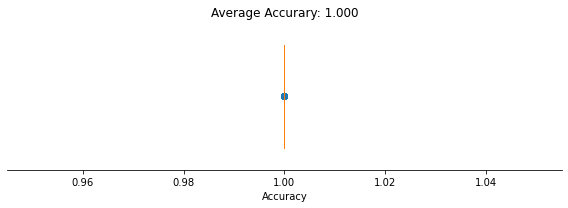

In [14]:
#@markdown Cross-validation, cv=8
num_splits =8
accuracies_A2_lin = (cross_val_score(model_A2_lin, visual_dat_hat, motor_dat_hat, cv=8))

f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies_A2_lin, vert=False, widths=.7)
ax.scatter(accuracies_A2_lin, np.ones(num_splits))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average Accurary: {np.mean(accuracies_A2_lin):.3f}"
)
ax.spines["left"].set_visible(False)

## Neural Network (third time lucky?)

iteration 600/3000 | loss: 68.887
iteration 1200/3000 | loss: 26.768
iteration 1800/3000 | loss: 15.477
iteration 2400/3000 | loss: 14.909
iteration 3000/3000 | loss: 14.879


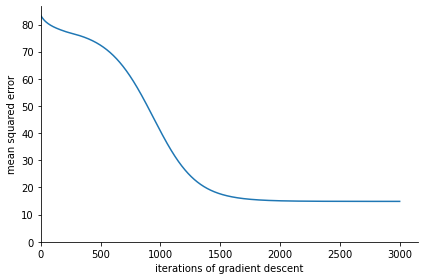

In [15]:
#@markdown DeepNet
import torch
from torch import nn
from torch import optim
class DeepNet(nn.Module):
  """Deep Network with one hidden layer

  Args:
    n_inputs (int): number of input units
    n_hidden (int): number of units in hidden layer

  Attributes:
    in_layer (nn.Linear): weights and biases of input layer
    out_layer (nn.Linear): weights and biases of output layer

  """

  def __init__(self, n_inputs, n_hidden, n_output):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    self.in_layer = nn.Linear(n_inputs, n_hidden) # neural activity --> hidden units
    self.out_layer = nn.Linear(n_hidden, n_output) # hidden units --> output

  def forward(self, r):
    """Decode stimulus orientation from neural responses

    Args:
      r (torch.Tensor): vector of neural responses to decode, must be of
        length n_inputs. Can also be a tensor of shape n_stimuli x n_inputs,
        containing n_stimuli vectors of neural responses

    Returns:
      torch.Tensor: network outputs for each input provided in r. If
        r is a vector, then y is a 1D tensor of length 1. If r is a 2D
        tensor then y is a 2D tensor of shape n_stimuli x 1.

    """
    h = torch.relu(self.in_layer(r))
    #h = self.in_layer(r)  # hidden representation
    y = self.out_layer(h)
    return y 

def train(net, loss_fn, train_data, train_labels, n_iter=3000, learning_rate=1e-4):

  # Initialize PyTorch SGD optimizer
  optimizer = optim.SGD(net.parameters(), lr=learning_rate)

  # Placeholder to save the loss at each iteration
  track_loss = []

  # Loop over epochs (cf. appendix)
  for i in range(n_iter):

    # Evaluate loss using loss_fn
    out = net(train_data)  # compute network output from inputs in train_data
    loss = loss_fn(out, train_labels)  # evaluate loss function

    # Compute gradients
    optimizer.zero_grad()
    loss.backward()

    # Update weights
    optimizer.step()

    # Store current value of loss
    track_loss.append(loss.item())  # .item() needed to transform the tensor output of loss_fn to a scalar

    # Track progress
    if (i + 1) % (n_iter // 5) == 0:
      print(f'iteration {i + 1}/{n_iter} | loss: {loss.item():.3f}')

  return track_loss

  # Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Vamos de 34 "neuronas" a que expliquen la actividad de "150" neuronas durante 219 trials
# Get total of neurons
_ , n_motor = motor_dat.shape
_, n_visual = visual_dat_hat.shape

motor_tensor = torch.tensor(motor_dat, dtype=torch.float32) # Response

#.unsqueeze(1)  # add singleton dimension to make a column vector <-- necesitamos esto?
visual_hat_tensor = torch.tensor(visual_dat_hat, dtype=torch.float32) # Stimulus 

# Initialize network
net = DeepNet(n_visual, 20, n_motor)

# Initialize built-in PyTorch MSE loss function
loss_fn = nn.MSELoss()

# Run GD on data
train_loss = train(net, loss_fn, visual_hat_tensor, motor_tensor )

# Plot the training loss over iterations of GD
plt.plot(train_loss)
plt.xlim([0, None])#
plt.ylim([0, None])
plt.xlabel('iterations of gradient descent')
plt.ylabel('mean squared error')
plt.show()  

# MODEL 3:  Decoding from motor 
Obtaining predicted motor that will be used on Model2

Logistic Regression 



**Metrics:**
*   Motor matrix `[nTrials x nNeurons]`: spikes rates of neurons from areas related to motor function. 

\begin{align}
\mathbf{M} = 
\begin{bmatrix}
y_{1,1} & y_{1,2} & \dots & y_{1,m}  \\
y_{2,1} & y_{2,2}  & \dots & y_{2,m} \\
\vdots & \vdots  & \dots & \vdots\\
y_{n,1} & y_{n,2} & \dots  &  y_{n,m}
\end{bmatrix}
\end{align}


*   Choice `[nTrials]`: 2 categories.  Task of turning a wheel to the left or to the rigth. *(NoGo trials were ignored for simplicity)*

\begin{align}
\mathbf{Choice} = 
\begin{bmatrix}
x_{1,1} & x_{1,2} & \dots & x_{1,m}  \\
\end{bmatrix}
\end{align}



**Returns**
* A3 `[nNeurons]`: Weight vector

\begin{align}
\mathbf{A3} = 
\begin{bmatrix}
\theta_{1,1} & \theta_{1,2}& \dots \ & \theta_{1,m}\\
\end{bmatrix}
\end{align}

* Motor matrix hat `[nTrials x nNeurons]`: predicted spikes rates of neurons from areas related to motor function.

\begin{align}
\mathbf{\hat M} = 
\begin{bmatrix}
y_{1,1} & y_{1,2} & \dots & y_{1,m}  \\
y_{2,1} & y_{2,2}  & \dots & y_{2,m} \\
\vdots & \vdots  & \dots & \vdots\\
y_{n,1} & y_{n,2} & \dots  &  y_{n,m}
\end{bmatrix}
\end{align}


In [16]:
# obtenemos matrices 'y' y 'x'
motor_dat = get_motor_ctx(data_set)
choice = data_set["response"]>0
#definimos el modelo & ajustamos los datos
model_A3 = LogisticRegression(fit_intercept=False,max_iter=5000).fit(motor_dat, choice)
A3 = model_A3.coef_.T
choice_hat = (sigmoid(motor_dat @ A3)>0.5).flatten()
#choice_hat = model_A3.predict(motor_dat)
acc = np.mean(choice==choice_hat)
print("ACC: {}".format(acc))
#print("MSE: {}".format(mse_A3))

ACC: 1.0


# Integrated Model
$$ \hat{choice} = sigmoid(stim A1 A2 A3) $$

**Metrics**
* stim `[nTrials x 3]` :  Visual stimulus, contrast on left and right

\begin{align}
\mathbf{X} = 
\begin{bmatrix}
1 & x_{1,1} & x_{1,2}  \\
1 & x_{2,1} & x_{2,2} \\
\vdots & \vdots & \vdots \\
1 & x_{n,1} & x_{n,2}
\end{bmatrix}
\end{align}


* A1 `[3 x nNeurons_visual]` : Weight matrix of encoding model (visual stimulus to visual area)

\begin{align}
\mathbf{A1} = 
\begin{bmatrix}
\theta_{1,1} & \theta_{1,2}& \dots \ & \theta_{1,m}\\
\theta_{2,1} & \theta_{2,2}& \dots & \theta_{2,m}\\
\theta_{3,1} & \theta_{3,2}& \dots & \theta_{3,m}\\
\end{bmatrix}
\end{align}


* A2 `[nNeurons_visual , nNeurons_motor]`: Weight  matrix of connectivity model (visual area to motor area)

\begin{align}
\mathbf{A2} = 
\begin{bmatrix}
\theta_{1,1} & \theta_{1,2}& \dots \ & \theta_{1,m}\\
\theta_{2,1} & \theta_{2,2}& \dots & \theta_{2,m}\\
\vdots & \vdots  & \dots & \vdots\\
\theta_{n,1} & \theta_{n,2}& \dots & \theta_{n,m}\\
\end{bmatrix}
\end{align}


* A3 `[nNeurons_motor]`: Weight vector of decoding model (motor area to task response)

\begin{align}
\mathbf{A3} = 
\begin{bmatrix}
\theta_{1,1} & \theta_{1,2}& \dots \ & \theta_{1,m}\\
\end{bmatrix}
\end{align}


In [17]:
choice_hat = (sigmoid(stim @ A1 @ A2 @ A3)>0.5).flatten()
acc = np.mean(choice==choice_hat)
print("ACC: {}".format(acc))

ACC: 0.8721461187214612


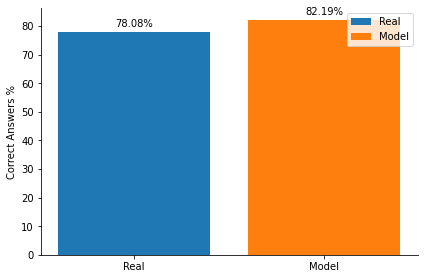

In [18]:
#@title Behavior Accuracy 
data_hat_set =  {
      "stims": stim, 
      "response": choice_hat*2 -1 
      }

binary_resp_behav=get_binary_response(data_set)
acc_behav= 100*(np.sum(binary_resp_behav==True)/len(binary_resp_behav))

binary_resp_model=get_binary_response(data_hat_set)
acc_behav_model= 100*(np.sum(binary_resp_model==True)/len(binary_resp_model))


labels = ["Behavior", "Model"]
#x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar( "Real", acc_behav,  label='Real')

rects2 = ax.bar("Model" , acc_behav_model,  label='Model')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Correct Answers %')


ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}%'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

plt.show()

# Perturbations

*  A1, A2 or A3 matrixes were randomly perturbated, setting  to 0.

Example, 50% of perturbation 

\begin{align}
\mathbf{Ax} = 
\begin{bmatrix}
0_{1,1} & \theta_{1,2}& \ 0_{1,3}& 0_{1,4}\\
\theta_{2,1} & 0_{2,2} & \ 0_{2,3}& \theta_{2,4}\\
0_{3,1} & \theta_{3,2} & \theta_{3,3}& \theta_{3,4}\\
\end{bmatrix}
\end{align}


In [19]:
def simulate_pertubations(weight_matrix, pct_lesion):
  n_rows,n_cols = weight_matrix.shape
  X = np.array(weight_matrix) # make a deep copy
  X[np.random.rand(n_rows,n_cols)<pct_lesion]=0
  return X

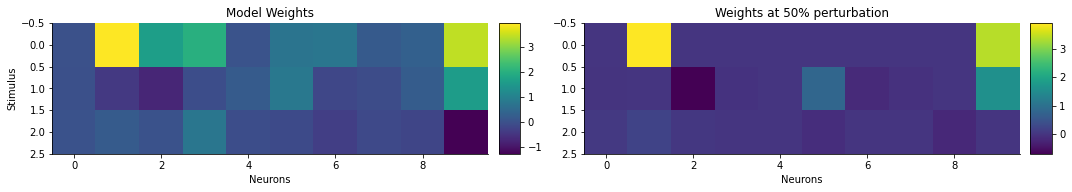

In [20]:
#@markdown Example of the perturbations on our weigth matrixes
from mpl_toolkits.axes_grid1 import make_axes_locatable
X= A1
X_perturbed = simulate_pertubations(A1, .5)

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
im0 = axs[0].imshow(X[:, :10])
im1 = axs[1].imshow(X_perturbed[:, :10])

divider = make_axes_locatable(axs[0])
cax0 = divider.append_axes("right", size="5%", pad=0.15)
plt.colorbar(im0, cax=cax0)
divider = make_axes_locatable(axs[1])
cax1 = divider.append_axes("right", size="5%", pad=0.15)
plt.colorbar(im1, cax=cax1)
axs[0].set_ylabel("Stimulus")
axs[1].set_xlabel("Neurons")
axs[0].set_xlabel("Neurons");
axs[0].set_title("Model Weights", )
axs[1].set_title("Weights at 50% perturbation");

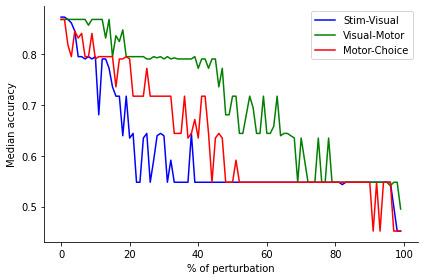

In [21]:
pct_lesions = np.linspace(.05, .99, 100)

n_sims = 100
acc_m = np.zeros((len(pct_lesions), 3))

for index,  pct_lesion in enumerate(pct_lesions):
  acc = np.zeros((3,100))
  for sim in range(n_sims):
    p_A1= simulate_pertubations(A1, pct_lesion) # p_A1 matrix of 0's
    p_A2= simulate_pertubations(A2, pct_lesion)
    p_A3= simulate_pertubations(A3, pct_lesion)
    p_choice = (sigmoid(stim @ p_A1 @ A2 @ A3)>0.5).flatten()
    acc[0,sim] = np.mean(choice==p_choice)
    p2_choice = (sigmoid(stim @ A1 @ p_A2 @ A3)>0.5).flatten()
    acc[1,sim] = np.mean(choice==p2_choice)
    p3_choice = (sigmoid(stim @ A1 @ A2 @ p_A3)>0.5).flatten()
    acc[2,sim] = np.mean(choice==p3_choice)
  
  acc_m[index] = np.median(acc,axis=1)

acc_m = acc_m.T
plt.plot(acc_m[0], label="Stim-Visual", color='blue', ) # A1
plt.plot(acc_m[1], label="Visual-Motor", color='green') 
plt.plot(acc_m[2], label="Motor-Choice", color='red')
plt.legend()

plt.xlabel('% of perturbation')
plt.ylabel('Median accuracy')
plt.show()  

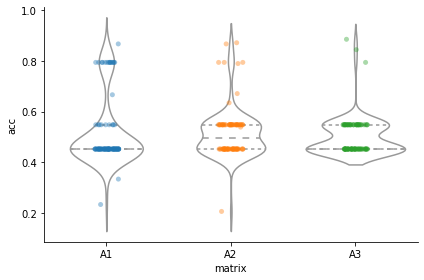

In [22]:
import seaborn as sns
import pandas as pd
acc_df = pd.DataFrame()
acc_df['acc'] = acc.flatten()
acc_df['matrix'] = np.repeat(['A1','A2','A3'],n_sims)
ax = sns.stripplot(x='matrix',y='acc',data=acc_df,alpha=0.4)
ax = sns.violinplot(x='matrix',y='acc',data=acc_df,ax=ax,color='white',inner='quartile')